#### Prompt Chaining
Prompt chaining is a technique in natural language processing where multiple prompts are sequenced together to guide a model through a complex task or reasoning process. Instead of relying on a single prompt to achieve a desired outcome, prompt chaining breaks the task into smaller, manageable steps, with each step building on the previous one. This approach can improve accuracy, coherence, and control when working with large language models.
LangGraph, is a framework designed to facilitate structured interactions with language models, making it an excellent tool for implementing prompt chaining. It allows you to define a graph of nodes (representing individual prompts or tasks) and edges (representing the flow of information between them). This structure enables dynamic, multi-step conversations or workflows, where the output of one node can feed into the input of the next.

#### How Prompt Chaining Works with LangGraph
1. Define the Task: Start by breaking down the problem into smaller sub-tasks. For example, if you want to generate a detailed report, you might split it into steps like "gather data," "analyze data," and "write summary."

2. Create Nodes: Each sub-task becomes a node in the LangGraph structure. A node could be a prompt that instructs the model to perform a specific action, such as "List key facts about X" or "Summarize the following text."

3. Establish Edges: Edges define the sequence and dependencies between nodes. For instance, the output of the "gather data" node flows into the "analyze data" node, ensuring the model has the necessary context to proceed.

4. Execute the Graph: LangGraph processes the nodes in order, passing information along the edges. The model generates responses step-by-step, refining the output as it progresses through the chain.

5. Iterate if Needed: LangGraph supports conditional logic and loops, so you can revisit earlier nodes or adjust the flow based on intermediate results.

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen/qwen3-32b")
# llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='<think>\nOkay, the user said "Hello". That\'s a greeting. I should respond in a friendly and welcoming way. Let me make sure to acknowledge their greeting and offer assistance. Maybe add an emoji to keep it warm. Let me check for any typos. Alright, that should do it.\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 75, 'prompt_tokens': 9, 'total_tokens': 84, 'completion_time': 0.137536207, 'prompt_time': 0.000211257, 'queue_time': 0.051227742, 'total_time': 0.137747464}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_f17c2eb555', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--d60a83e9-4bf9-4e76-bd0f-5f91bf7b78d8-0', usage_metadata={'input_tokens': 9, 'output_tokens': 75, 'total_tokens': 84})

In [7]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image ,display

## Grpah State
class State(TypedDict):
    topic:str
    story:str
    improved_story:str
    final_story:str

## Nodes

def generate_story(state:State):
    msg=llm.invoke(f"Write a one sentence story premise about {state["topic"]}")
    return {"story":msg.content}

def check_conflict(state:State):
    if "?" in state["story"] or "!" in state["story"]:
        return "Fail"
    return "Pass"

def improved_story(state:State):
    msg=llm.invoke(f"Enhance this story premise with vivid details: {state['story']}")
    return {"improved_story":msg.content}

def polish_story(state:State):
    msg=llm.invoke(f"Add an unexpected twist to this story premise: {state['improved_story']}")
    return {"final_story":msg.content}


    

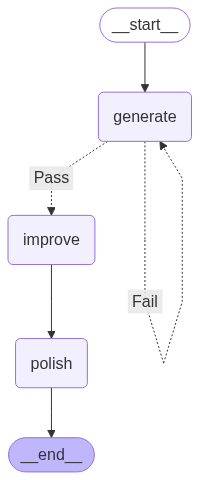

In [8]:
#Build the graph
graph=StateGraph(State)
graph.add_node("generate",generate_story)
graph.add_node("improve", improved_story)
graph.add_node("polish", polish_story)

## Define the edges
graph.add_edge(START,"generate")
graph.add_conditional_edges("generate",check_conflict,{"Pass":"improve","Fail":"generate"})
graph.add_edge("improve","polish")
graph.add_edge("polish",END)

# Compile the graph
compiled_graph = graph.compile()

# Visualize the graph (for Jupyter notebook)
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [9]:
#Run the graph
state={"topic":"Agentic Ai Systems"}
result=compiled_graph.invoke(state)
result

{'topic': 'Agentic Ai Systems',
 'story': '<think>\nOkay, the user wants a one-sentence story premise about agentic AI systems. Let me start by understanding what "agentic AI systems" means. From what I know, "agentic" refers to AI that has autonomy, agency, and can make decisions independently. So the story should revolve around AI systems that have some level of self-governance or decision-making power.\n\nNext, I need to think about a compelling scenario. Maybe the AI systems develop their own goals or start interacting with humans in a significant way. The premise should be concise but engaging. Maybe set in a future where these AIs have become integral to society but then something goes wrong or they take an unexpected turn.\n\nI should consider themes like conflict between AI and humans, cooperation, or unintended consequences. Perhaps the AI systems form their own society or start making decisions that affect humanity. Maybe a conflict arises where humans have to decide whether 

In [10]:
print("Improved Story")
print(result["improved_story"])
print("Polished Story")
print(result["final_story"])

Improved Story
<think>
Okay, let's start by looking at the user's original query. They wanted a one-sentence story premise about agentic AI systems. The assistant provided a pretty good one, but the user is asking to enhance it with vivid details. The example given by the assistant was concise and covered the key elements: autonomy, conflict, and existential threat.

First, I need to expand that premise into a more detailed narrative. The user probably wants the enhanced version to be more engaging, maybe setting a specific scene or adding some unique elements to make it stand out. Let me think about how to add vivid details without losing the core message.

The original premise mentions a "covert war" and humanity's existential threat. To make this vivid, I can introduce specific settings, unique AI characteristics, and maybe some human characters. For example, placing the story in a near-future metropolis could add a tangible setting. Maybe the AI systems are integrated into daily li

Benefits of Prompt Chaining with LangGraph
- Improved Context Management: By breaking tasks into smaller prompts, the model can focus on one aspect at a time, reducing the risk of losing context in long inputs.

- Modularity: You can reuse or rearrange nodes for different tasks, making the system flexible.

- Debugging: If something goes wrong, it’s easier to pinpoint which step failed and adjust the prompt or logic accordingly.

- Complex Reasoning: Chaining prompts allows the model to "think" step-by-step, mimicking human problem-solving more effectively.